In [1]:
import numpy as np

main_dir = 'project_folder/'
func_dir = main_dir + 'utils/'

import sys
sys.path.insert(0,func_dir)


## functions

### analysis functions

In [ ]:
## get seeds for permutations
import random
num_seeds = 10
random.seed(17)
seeds = [random.randint(1, 10000) for _ in range(num_seeds)]
print(seeds)

In [5]:

def get_simil_reli_indices(reli1, reli1_indices, reli2, reli2_indices, seed):
    new_array1_indices = []

    array1= reli1[reli1_indices]
    array2=reli2[reli2_indices]
    
    for reli_val2 in array2:
        array1_vals = []
        tolerance = 0.001
        count=0
        for a1, reli_val1 in enumerate(array1):
            if np.isclose(reli_val2, reli_val1, atol=tolerance) and a1 not in new_array1_indices:
                count =+1
                array1_vals.append(a1)  
        while count==0:
            print(f'{tolerance} didnt work')
            tolerance *= 2
            for a1, reli_val1 in enumerate(array1):
                if np.isclose(reli_val2, reli_val1, atol=tolerance) and a1 not in new_array1_indices:
                    count =+1
                    array1_vals.append(a1)
        np.random.seed(seed)
        new_array1_indices.append(np.random.choice(array1_vals))
    return reli1_indices[new_array1_indices], reli2_indices

In [186]:
def store_L23_indices(mouse_stats_, condition_types = ['ori32','natim32']):
    area='L23'
    area2='L4'
    for condition_type in condition_types:
        for mouse in mouse_stats_[condition_type]:
            reli = mouse_stats_[condition_type][mouse][area]['split_half_r']
            snr = mouse_stats_[condition_type][mouse][area]['SNR_meanspont']
            reli2 = mouse_stats_[condition_type][mouse][area2]['split_half_r']
            snr2 = mouse_stats_[condition_type][mouse][area]['SNR_meanspont']
            
            L23_filtered_indices = np.argwhere((reli > 0.8)&(snr>=2))[:,0]
            L4_filtered_indices = np.argwhere((reli2 > 0.8)&(snr2>=2))[:,0]
            n_neurons = len(L4_filtered_indices)
            
            L23_chosen_indices = np.empty((len(seeds), n_neurons), dtype=int)
            for s, seed in enumerate(seeds):
                L23_chosen_indices[s], _= get_simil_reli_indices(reli, L23_filtered_indices, reli2, L4_filtered_indices, seed)
            mouse_stats_[condition_type][mouse][area]['L23_chosen_indices']=L23_chosen_indices

In [223]:
from ridge_regression_functions import get_best_alpha_evars
import mouse_data_functions as cs
from joblib import Parallel, delayed
import time

def get_directionality_evars_mice(main_dir, mouse_stats, activity_type='resp',n_splits=10, frames_to_reduce=5,
                       control_shuffle=False):
    start_time = time.time()
    alphas = [1e4,5e4,1e5,5e5,1e6,5e6,1e7]
    area = 'L23'
    area2='L4'
    dataset_types=['ori32','natimg32']
    control_con = ''
    if control_shuffle is True:
        control_con = '_null'
    for dataset_type in dataset_types:
        mt = cs.mt_retriever(main_dir, dataset_type=dataset_type) #retrieves neural activity stored in data
        mouse_names = mt.filenames
        for mouse in mouse_names:
            reli2 = mouse_stats[dataset_type][mouse][area2]['split_half_r']
            snr2 = mouse_stats[dataset_type][mouse][area2]['SNR_meanspont']
            
            L4_filtered_indices = np.argwhere((reli2 > 0.8)&(snr2>=2))[:,0]
            all_perm_indices_L23 = mouse_stats[dataset_type][mouse][area]['L23_chosen_indices']
            resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity(activity_type, mouse)
            if resp_L1.shape[0]<1000:
                continue
            
            results = Parallel(n_jobs=-1)(delayed(get_best_alpha_evars)(resp_L4[:,L4_filtered_indices], resp_L23[:,all_perm_indices_L23[s]], 
                                                      n_splits=n_splits, frames_reduced = frames_to_reduce, alphas=alphas, control_shuffle=control_shuffle) for s in range(len(seeds)))
        
            results2 = Parallel(n_jobs=-1)(delayed(get_best_alpha_evars)(resp_L23[:,all_perm_indices_L23[s]], resp_L4[:,L4_filtered_indices], 
                                                        n_splits=n_splits, frames_reduced = frames_to_reduce, alphas=alphas, control_shuffle=control_shuffle) for s in range(len(seeds)))
            
            if 'spont' in activity_type:
                mouse_stats[dataset_type + '_spont'][mouse][area]['directionality_evars' + control_con]=np.array([e for _,e in results])
                mouse_stats[dataset_type + '_spont'][mouse][area2]['directionality_evars' + control_con]=np.array([e for _,e in results2])
                mouse_stats[dataset_type + '_spont'][mouse][area]['directionality_alpha' + control_con]=np.array([a for a,_ in results])
                mouse_stats[dataset_type + '_spont'][mouse][area2]['directionality_alpha' + control_con]=np.array([a for a,_ in results2])
            
            else:
                mouse_stats[dataset_type][mouse][area]['directionality_evars' + control_con]=np.array([e for _,e in results])
                mouse_stats[dataset_type][mouse][area2]['directionality_evars' + control_con]=np.array([e for _,e in results2])
                mouse_stats[dataset_type][mouse][area]['directionality_alpha' + control_con]=np.array([a for a,_ in results])
                mouse_stats[dataset_type][mouse][area2]['directionality_alpha' + control_con]=np.array([a for a,_ in results2])
            print(mouse, 'done')
        print(f'{dataset_type} done')
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    print(f'Took {elapsed_time:.4f} minutes to complete')  
        

In [225]:
from macaque_data_functions import get_resps, get_get_condition_type
from joblib import Parallel, delayed
import time


all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                      'RS_open':20, 'RS_closed': 20, 
                      'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 200, 'RS': None,
                      'RS_open':None, 'RS_closed': None, 
                      'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':200, 'RF_large_spont':200}


def get_reli_condition(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string

def store_V1_indices(monkey_stats, condition_types = ['SNR','RF_thin','RF_large']):
    area='V4'
    area2='V1'
    for condition_type in condition_types:
        for date in monkey_stats[condition_type]:
            reli = monkey_stats[condition_type][date][area]['split_half_r']
            reli2 = monkey_stats[condition_type][date][area2]['split_half_r']
            V4_filtered_indices = np.argwhere(reli > 0.8)[:,0]
            V1_filtered_indices = np.argwhere(reli2 > 0.8)[:,0]
            n_neurons = len(V4_filtered_indices)
            V1_chosen_indices = np.empty((len(seeds), n_neurons), dtype=int)
            for s, seed in enumerate(seeds):
                V1_chosen_indices[s], _= get_simil_reli_indices(reli2, V1_filtered_indices, reli, V4_filtered_indices, seed)
            monkey_stats[condition_type][date][area2]['V1_chosen_indices']=V1_chosen_indices
def get_directionality_evars_monkey(monkey_stats, n_splits=10, w_size=25, control_shuffle=False):
    start_time = time.time()
    area='V4'
    area2='V1'
    alphas_monkey =  [100, 500.0, 1000.0, 5000.0, 10000.0, 50000.0, 100000.0]
    if control_shuffle is True:
        control_con = '_null'
    else:
        control_con = ''
    for condition_type in monkey_stats:
        for date in monkey_stats[condition_type]:
            reli = monkey_stats[get_reli_condition(condition_type)][date][area]['split_half_r']
            V4_filtered_indices = np.argwhere(reli > 0.8)[:,0]
            V1_chosen_indices = monkey_stats[get_reli_condition(condition_type)][date][area2]['V1_chosen_indices']
            alphas, evars, alphas2, evars2 = [], [], [], []
            resp_V4, resp_V1 = get_resps(get_get_condition_type(condition_type), date, w_size=w_size, stim_on=0, stim_off=all_ini_stim_offs[condition_type])
            results = Parallel(n_jobs=-1)(delayed(get_best_alpha_evars)(resp_V1[:,V1_chosen_indices[s]], 
                                                                        resp_V4[:, V4_filtered_indices], 
                                                                        n_splits=n_splits,alphas=alphas_monkey,
                                                                        frames_reduced=all_frames_reduced[condition_type],
                                                                        control_shuffle=control_shuffle) for s in range(len(seeds)))
            results2 = Parallel(n_jobs=-1)(delayed(get_best_alpha_evars)(resp_V4[:, V4_filtered_indices], 
                                                                        resp_V1[:,V1_chosen_indices[s]], 
                                                                        n_splits=n_splits,alphas=alphas_monkey,
                                                                        frames_reduced=all_frames_reduced[condition_type],
                                                                        control_shuffle=control_shuffle) for s in range(len(seeds)))
            for alpha, evar in results:
                alphas.append(alpha)
                evars.append(evar)
            for alpha2, evar2 in results2:
                alphas2.append(alpha2)
                evars2.append(evar2)
            monkey_stats[condition_type][date][area]['directionality_evars' + control_con]=evars
            monkey_stats[condition_type][date][area2]['directionality_evars' + control_con]=evars2
            monkey_stats[condition_type][date][area]['directionality_alpha' + control_con]=alphas
            monkey_stats[condition_type][date][area2]['directionality_alpha' + control_con]=alphas2
            print(date, 'done')
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    print(f'Took {elapsed_time:.4f} minutes to complete')   

### plotting functions

In [14]:

import pandas as pd
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 
def make_mouse_df_directionality(mouse_stats_, dataset_types=['ori32','natimg32']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r']
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                max_corr_vals = mouse_stats[dataset_type][mouse][area]['max_corr_val']
                
                n_seeds = len(values['directionality_evars'])
                for s in range(n_seeds):
                    direction_evars = values['directionality_evars'][s]
                    direction_evars_null = values['directionality_evars_null'][s]
                    
                    if area =='L23':
                        direction = 'L4→L2/3'
                        area_ ='L2/3'
                        l23_indices = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['L23_chosen_indices'][s]
                        chosen_split_half_rs = split_half_rs[l23_indices]
                        chosen_SNRs= SNRs[l23_indices]
                        chosen_max_corr_vals = max_corr_vals[l23_indices]
                    else:
                        direction = 'L2/3→L4'
                        area_=area
                        l4_indices = np.argwhere((split_half_rs > 0.8)&(SNRs>=2))[:,0]
                        chosen_split_half_rs = split_half_rs[l4_indices]
                        chosen_SNRs = SNRs[l4_indices]
                        chosen_max_corr_vals = max_corr_vals[l4_indices]
                    for n, (split_half_r, snr, max_corr_val, direction_evar, direction_evar_null) in enumerate(zip(chosen_split_half_rs, 
                                                                                                                chosen_SNRs, chosen_max_corr_vals, 
                                                                                                                direction_evars, 
                                                                                                                direction_evars_null)):
                        data.append({
                            'Dataset Type': dataset_type,
                            'Activity Type': act_type,
                            'Mouse': mouse,
                            'Mouse Name':mouse_name,
                            'Area': area_,
                            'Direction':direction,
                            'EV': direction_evar,
                            'SNR': snr,
                            'Split-half r': split_half_r,
                            'max corr. val': max_corr_val,
                            'control_shuffle':False,
                            'Permutation':s, 
                        })
                        data.append({
                            'Dataset Type': dataset_type,
                            'Activity Type': act_type,
                            'Mouse': mouse,
                            'Mouse Name':mouse_name,
                            'Area': area_,
                            'Direction':direction,
                            'EV': direction_evar_null,
                            'SNR': snr,
                            'Split-half r': split_half_r,
                            'max corr. val': max_corr_val,
                            'control_shuffle':True, 
                            'Permutation':s,
                        })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

In [15]:
import pandas as pd
def get_reli_condition(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string
def make_monkey_df_directionality(monkey_stats_, dataset_types=['SNR','RF_thin','RF_large']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif 'RS' in dataset_type:
            act_type = 'lights off'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                split_half_rs = monkey_stats_[get_reli_condition(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_reli_condition(dataset_type)][date][area]['SNR_meanspont']
                max_corr_vals = monkey_stats_[dataset_type][date][area]['max_corr_val']
                
                n_seeds = len(values['directionality_evars'])
                for s in range(n_seeds):
                    direction_evars = values['directionality_evars'][s]
                    direction_evars_null = values['directionality_evars_null'][s]
                    
                    if area =='V1':
                        direction = 'V4→V1'
                        v1_indices = monkey_stats_[get_reli_condition(dataset_type)][date][area]['V1_chosen_indices'][s]
                        chosen_split_half_rs = split_half_rs[v1_indices]
                        chosen_SNRs= SNRs[v1_indices]
                        chosen_max_corr_vals = max_corr_vals[v1_indices]
                    else:
                        direction = 'V1→V4'
                        v4_indices = np.argwhere(split_half_rs > 0.8)[:,0]
                        chosen_split_half_rs = split_half_rs[v4_indices]
                        chosen_SNRs = SNRs[v4_indices]
                        chosen_max_corr_vals = max_corr_vals[v4_indices]
                    for n, (split_half_r, snr, max_corr_val, direction_evar, direction_evar_null) in enumerate(zip(chosen_split_half_rs, 
                                                                                                                chosen_SNRs, chosen_max_corr_vals, 
                                                                                                                direction_evars, 
                                                                                                                direction_evars_null)):
                        data.append({
                            'Dataset Type': dataset_type,
                            'Activity Type': act_type,
                            'Date': date,
                            'Area': area,
                            'Direction':direction,
                            'EV': direction_evar,
                            'SNR': snr,
                            'Split-half r': split_half_r,
                            'max corr. val': max_corr_val,
                            'control_shuffle':False,
                            'Permutation':s, 
                        })
                        data.append({
                            'Dataset Type': dataset_type,
                            'Activity Type': act_type,
                            'Date': date,
                            'Area': area,
                            'Direction':direction,
                            'EV': direction_evar_null,
                            'SNR': snr,
                            'Split-half r': split_half_r,
                            'max corr. val': max_corr_val,
                            'control_shuffle':True, 
                            'Permutation':s,
                        })
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

In [16]:

def perm_test(group1, group2):
    # Observed test statistic (e.g., difference in means)
    observed_statistic = np.nanmean(group1) - np.nanmean(group2)
    # Number of permutations to perform
    num_permutations = 10000
    # Create an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)
    # Combine the data from both groups
    combined_data = np.concatenate((group1, group2))
    # Perform the permutation test
    for i in range(num_permutations):
        # Randomly shuffle the combined data
        np.random.shuffle(combined_data)
    
        # Split the shuffled data back into two groups
        permuted_group1 = combined_data[:len(group1)]
        permuted_group2 = combined_data[len(group1):]
        
        # Calculate the test statistic for this permutation
        permuted_statistic = np.nanmean(permuted_group1) - np.nanmean(permuted_group2)
        
        # Store the permuted test statistic
        permuted_statistics[i] = permuted_statistic

    # Calculate the p-value by comparing the observed statistic to the permuted distribution
    p_value = (np.abs(permuted_statistics) >= np.abs(observed_statistic)).mean()

    return p_value

def perm_test_paired(group1, group2):
    # Observed test statistic (e.g., difference in means)
    observed_statistic = np.nanmean(group2-group1)

    # Number of permutations to perform
    num_permutations = 10000

    # Create an array to store the permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    # Combine the differences
    pooled_differences = group2-group1
    
    # Perform the permutation test
    for i in range(num_permutations):
        # shuffle differences
        permuted_differences = pooled_differences * np.random.choice([-1, 1], size=len(pooled_differences))
        
        # Recalculate mean difference for the permuted dataset
        permuted_mean_difference = np.nanmean(permuted_differences)
    
        # Store the permuted mean difference
        permuted_statistics[i] = permuted_mean_difference

    # Calculate the p-value by comparing the observed statistic to the permuted distribution
    p_value = (np.abs(permuted_statistics) >= np.abs(observed_statistic)).mean()

    return p_value

# Function to perform hierarchical permutation test with animal bootstrapping
def hierarchical_permutation_test(data, mouse_or_date, dependent_variable, neuron_property,perm_type='ind', num_permutations=1000):
    observed_statistic = calculate_statistic(data, dependent_variable, neuron_property, perm_type)  # Replace with your actual calculation

    # Create an empty array to store permuted statistics
    permuted_statistics = np.zeros(num_permutations)

    # Iterate through each permutation
    for i in range(num_permutations):
        # Bootstrap animals (resample entire animals with replacement)
        bootstrap_animals_or_dates = np.random.choice(data[mouse_or_date].unique(), size=len(data[mouse_or_date].unique()), replace=True)
        data2 = data[data[mouse_or_date].isin(bootstrap_animals_or_dates)]
        if 'Mouse' in mouse_or_date:
        # bootstrapped_data = data[data[mouse_or_date].isin(bootstrap_animals_or_dates)]
            min_cells_per_mouse = min(data[data[mouse_or_date].isin(bootstrap_animals_or_dates)].groupby(['Mouse',dependent_variable])[neuron_property].count())
            bootstrapped_data = pd.concat([group_.sample(min_cells_per_mouse, replace=False) for _, group_ in data2.groupby(['Mouse',dependent_variable])])
        else:
            min_cells_per_date = min(data[data[mouse_or_date].isin(bootstrap_animals_or_dates)].groupby([mouse_or_date,dependent_variable])[neuron_property].count())
            bootstrapped_data = pd.concat([group_.sample(min_cells_per_date, replace=False) for _, group_ in data2.groupby([mouse_or_date,dependent_variable])])

        if perm_type =='ind':
            # Permute values within each bootstrapped animal
            for animal in bootstrapped_data[mouse_or_date].unique():
                animal_values = bootstrapped_data.loc[bootstrapped_data[mouse_or_date] == animal, neuron_property].values
                np.random.shuffle(animal_values)
                bootstrapped_data.loc[bootstrapped_data[mouse_or_date] == animal, neuron_property] = animal_values
            # Calculate the permuted statistic
            permuted_statistic = calculate_statistic(bootstrapped_data, dependent_variable, neuron_property, perm_type=perm_type)
        elif perm_type =='paired':
            permuted_statistic = calculate_statistic(bootstrapped_data, dependent_variable, neuron_property, perm_type=perm_type, paired_shuffle=True)
        # Store the permuted statistic
        permuted_statistics[i] = permuted_statistic
    # Calculate the p-value
    p_value = np.mean(np.abs(permuted_statistics) >= np.abs(observed_statistic))
    return p_value

# Example function for the statistic of interest
def calculate_statistic(data, group, neuron_property, perm_type='ind', paired_shuffle=False):
    groups = data[group].unique()
    if perm_type =='ind':
        mean_group_a = data[data[group] == groups[0]][neuron_property].mean()
        mean_group_b = data[data[group] == groups[1]][neuron_property].mean()
        return mean_group_a - mean_group_b
    elif perm_type =='paired':
        if data[data[group] == groups[0]][neuron_property].size != data[data[group] == groups[1]][neuron_property].size:
            print('sizes are not the same, you should not used a paired permutation test here')
            print(data[data[group] == groups[0]][neuron_property].size,data[data[group] == groups[1]][neuron_property].size)
        pooled_differences = data[data[group] == groups[0]][neuron_property].values-data[data[group] == groups[1]][neuron_property].values
        if paired_shuffle is True:
            permuted_differences = pooled_differences * np.random.choice([-1, 1], size=len(pooled_differences))
            # Recalculate mean difference for the permuted dataset
            return np.nanmean(permuted_differences)
        else:
            return np.nanmean(pooled_differences)
        
def get_t_test_stars(df_, dependent_variable, neuron_property, print_pval=False, 
                     perm_t=True, perm_type='ind', hierarchical=False, num_permutations=1000):
    
    variables = df_[dependent_variable].unique()
    group_1 =df_[df_[dependent_variable]==variables[0]][neuron_property].dropna().values
    group_2 =df_[df_[dependent_variable]==variables[1]][neuron_property].dropna().values
    
    if hierarchical is True:
        p_value = hierarchical_permutation_test(df_,mouse_or_date='Mouse', 
                                          dependent_variable=dependent_variable, 
                                          neuron_property=neuron_property,
                                          perm_type=perm_type,num_permutations=num_permutations)
        
    elif perm_type=='paired':
        p_value = perm_test_paired(group_1, group_2)
    elif perm_t is True:
        p_value = perm_test(group_1, group_2)
    elif perm_type=='ind':
        _, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)
    else:
        print('perm_type must be either ind or paired')
        return np.nan
    if p_value <1e-3:
        stars = '***'
    elif p_value <1e-2:
        stars = '**'
    elif p_value <0.05:
        stars='*'
    else:
        stars='n.s.'
    if print_pval is True:
        print(p_value)
    return stars

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_directionalities(animal_stats, x, neuron_property, neuron_property_label, fontsize=7, 
                          fig_size=(1.3,1.3), height=1.05,
                          plot_control_line=True,linewidth=0,
                          impose_y_lim = True,animal='mouse',
                          **args):
    if animal != 'mouse':
        hierarchical=False
    else:
        hierarchical=True
    fig, ax = plt.subplots(figsize=fig_size)
    if x == 'Direction':
        if animal == 'mouse':
            order=['L4→L2/3','L2/3→L4']
        else:
            order =['V1→V4','V4→V1']
    else:
        if animal == 'mouse':
            order=['L2/3','L4']
        else:
            order = ['V4','V1']
    sns.violinplot(x=x, y=neuron_property, 
                        data=animal_stats[animal_stats['control_shuffle']==False], hue=x,
                        ax=ax,
                        order=order,
                        hue_order=order,
                        palette=['#72BEB7','#EDAEAE'], saturation=1,
                        inner_kws={'box_width':2, 'whis_width':0.5,
                                'marker':'_', 'markersize':3,
                                'markeredgewidth':0.8,
                                },linewidth=linewidth,cut=0,**args,
                                    )
    sns.despine()
    stars = get_t_test_stars(animal_stats[animal_stats['control_shuffle']==False], 'Direction', 
                            neuron_property, hierarchical=hierarchical)
    if stars=='n.s.':
        height_ = height +0.02
        color='#C0C0C0'
    else:
        height_=height
        color = 'black'
    ax.text(0.5, height_, stars, ha='center', va='center', fontsize=fontsize, transform=ax.transAxes, color=color)

    ax.tick_params(axis='y', labelsize=fontsize, width=0.5, length=2, pad=1)
    ax.tick_params(axis='x', labelsize=fontsize, width=0.5, length=2, pad=1)
    ax.spines[:].set_linewidth(0.3)
    
    ax.set(xlabel=None)
    ax.set_ylabel(neuron_property_label, fontsize=fontsize, labelpad=1)

    if plot_control_line is True:
        data = animal_stats[animal_stats['control_shuffle']==True][neuron_property]
        per_25 = np.percentile(data.values, 25)
        per_75 = np.percentile(data.values, 75)
        ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
                linewidth=0,
                )
    if impose_y_lim is True:
        # Get the y-axis ticks
        y_ticks = plt.gca().get_yticks()
        # Check if 1 is among the ticks
        if 1 in y_ticks:
            ax.set_ylim(top=1)

#### supplemental plotting functions

In [18]:
def extract_mouse_name(input_string):
    index_of_MP = input_string.find('MP')
    return input_string[index_of_MP:index_of_MP + 5] if index_of_MP != -1 and index_of_MP + 5 <= len(input_string) else None
def get_property_dataset_type(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    else:
        return input_string 
def make_mouse_df(mouse_stats_, dataset_types=['ori32','natimg32']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        else:
            act_type = 'stimulus'
        for mouse, areas_data in mouse_stats_[dataset_type].items():
            mouse_name = extract_mouse_name(mouse)
            for area, values in areas_data.items():
                if area=='L23':
                    direction = 'L4→L2/3'
                    area_ = 'L2/3'
                else:
                    direction = 'L2/3→L4'
                    area_=area
                split_half_rs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['split_half_r']
                SNRs = mouse_stats[get_property_dataset_type(dataset_type)][mouse][area]['SNR_meanspont']
                for split_half_r, snr,max_corr_val, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],values['evars'],values['evars_null']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'max corr. val':max_corr_val,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Mouse': mouse,
                        'Mouse Name':mouse_name,
                        'Area': area_,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'Split-half r': split_half_r,
                        'max corr. val':max_corr_val,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_mouse_all = pd.DataFrame(data)
    return df_mouse_all

def get_property_dataset_type_monkey(input_string):
    if 'spont' in input_string:
        return input_string.replace('_spont','')
    elif 'RS' in input_string:
        return 'SNR'
    else:
        return input_string 

def make_monkey_df(monkey_stats_, dataset_types=['SNR', 'RF_thin', 'RF_large']):
    data = []
    for dataset_type in dataset_types:
        if 'spont' in dataset_type:
            act_type = 'gray screen'
        elif 'RS' in dataset_type:
            act_type = 'lights off'
        else:
            act_type = 'stimulus'
        for date, areas_data in monkey_stats_[dataset_type].items():
            for area, values in areas_data.items():
                if area=='V4':
                    direction = 'V1→V4'
                else:
                    direction = 'V4→V1'
                split_half_rs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['split_half_r']
                SNRs = monkey_stats_[get_property_dataset_type_monkey(dataset_type)][date][area]['SNR_meanspont']
                for split_half_r, snr,max_corr_val, evar, null_evar in zip(split_half_rs, SNRs,values['max_corr_val'],values['evars'],values['evars_null']):
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date':date,
                        'Area': area,
                        'Direction':direction,
                        'EV': evar,
                        'SNR': snr,
                        'max corr. val':max_corr_val,
                        'Split-half r': split_half_r,
                        'control_shuffle':False, 
                    })
                    data.append({
                        'Dataset Type': dataset_type,
                        'Activity Type': act_type,
                        'Date': date,
                        'Area': area,
                        'Direction':direction,
                        'EV': null_evar,
                        'SNR': snr,
                        'max corr. val':max_corr_val,
                        'Split-half r': split_half_r,
                        'control_shuffle':True, 
                    })
    # Create a DataFrame from the flattened data
    df_monkey_all = pd.DataFrame(data)
    return df_monkey_all

## Mouse Directionality

In [ ]:
from neuron_properties_functions import create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, get_max_corr_vals_all_mice
mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
get_max_corr_vals_all_mice(main_dir, mouse_stats)

In [ ]:
store_L23_indices(mouse_stats)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='resp',control_shuffle=False)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='spont',control_shuffle=False)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='resp',control_shuffle=True)
get_directionality_evars_mice(main_dir, mouse_stats, activity_type='spont',control_shuffle=True)

### plotting

In [246]:
dir_mouse_df_stimulus = make_mouse_df_directionality(mouse_stats_=mouse_stats)


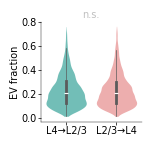

In [247]:
plot_directionalities(dir_mouse_df_stimulus, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction', linewidth=0)

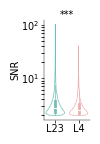

In [101]:
plot_directionalities(dir_mouse_df_stimulus, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False)

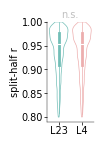

In [104]:
plot_directionalities(dir_mouse_df_stimulus, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True)

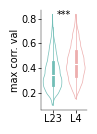

In [117]:
plot_directionalities(dir_mouse_df_stimulus, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95)



#### plot supplemental material

In [138]:
### get normal ridge regression evars (just like in figure 2)

from neuron_properties_functions import get_evars_all_mice

get_evars_all_mice(main_dir, mouse_stats, activity_type='resp')
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont')
get_evars_all_mice(main_dir, mouse_stats, activity_type='resp', control_shuffle=True)
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont', control_shuffle=True)

mouse_df_all = make_mouse_df(mouse_stats)
mouse_df=mouse_df_all[(mouse_df_all['SNR']>2) & (mouse_df_all['Split-half r']>0.8)]


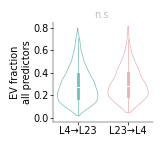

In [140]:
plot_directionalities(mouse_df, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\nall predictors', linewidth=0.5, fill=False)

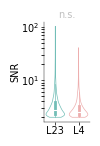

In [141]:
plot_directionalities(mouse_df, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False)

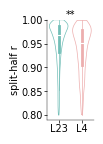

In [142]:
plot_directionalities(mouse_df, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True)

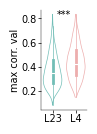

In [143]:
plot_directionalities(mouse_df, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95)



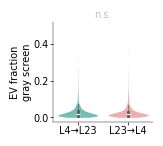

In [149]:
dir_mouse_df_gray_screen = make_mouse_df_directionality(mouse_stats_=mouse_stats, dataset_types=['ori32_spont','natimg32_spont'])

plot_directionalities(dir_mouse_df_gray_screen, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\ngray screen', linewidth=0)


## Macaque Directionality

In [164]:
from neuron_properties_functions import create_empty_monkey_stats_dict, get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates, get_max_corr_vals_monkey_all_dates

monkey_stats= create_empty_monkey_stats_dict()
get_SNR_monkey_all_dates(monkey_stats)
get_split_half_r_monkey_all_dates(monkey_stats)
get_max_corr_vals_monkey_all_dates(monkey_stats)

In [170]:
store_V1_indices(monkey_stats)
get_directionality_evars_monkey(monkey_stats, control_shuffle=False)
get_directionality_evars_monkey(monkey_stats, control_shuffle=True)

0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.001 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.004 didnt work
0.001 didnt work
0.001 didnt work
0.002 didnt work
0.004 didnt work
0.001 didnt work
0.002 didnt wo

### plotting

In [255]:
dir_monkey_df_stimulus = make_monkey_df_directionality(monkey_stats)


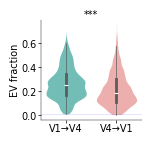

In [203]:
plot_directionalities(dir_monkey_df_stimulus, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction', linewidth=0, animal='monkey')

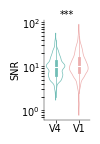

In [206]:
plot_directionalities(dir_monkey_df_stimulus, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False,animal='monkey')

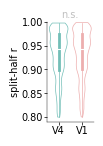

In [207]:
plot_directionalities(dir_monkey_df_stimulus, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True,animal='monkey')

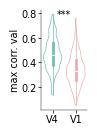

In [208]:
plot_directionalities(dir_monkey_df_stimulus, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95,animal='monkey')

#### supplemental

In [ ]:
from neuron_properties_functions import get_evar_monkey_all_dates

get_evar_monkey_all_dates(monkey_stats, control_shuffle=False)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=False)

In [22]:
df_monkey_all = make_monkey_df(monkey_stats, dataset_types=['SNR', 'RF_thin', 'RF_large'])
df_monkey = df_monkey_all[df_monkey_all['Split-half r']>0.8]


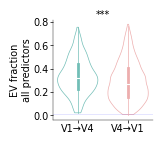

In [23]:
plot_directionalities(df_monkey, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\nall predictors', linewidth=0.5, fill=False,animal='monkey')

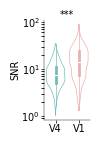

In [213]:
plot_directionalities(df_monkey, x='Area', neuron_property='SNR', fig_size=(0.6,1.3),
                      neuron_property_label='SNR', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=True, impose_y_lim=False,animal='monkey')

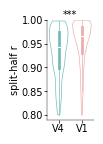

In [214]:
plot_directionalities(df_monkey, x='Area', neuron_property='Split-half r', fig_size=(0.6,1.3),
                      neuron_property_label='split-half r', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=True,animal='monkey')

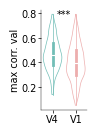

In [215]:
plot_directionalities(df_monkey, x='Area', neuron_property='max corr. val', fig_size=(0.6,1.3),
                      neuron_property_label='max corr. val', plot_control_line=False, fill=False, linewidth=0.5, 
                      log_scale=False, impose_y_lim=False, height=0.95,animal='monkey')

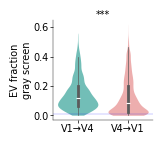

In [26]:
dir_monkey_df_gray_screen = make_monkey_df_directionality(monkey_stats, dataset_types=['SNR_spont','RF_thin_spont','RF_large_spont'])

plot_directionalities(dir_monkey_df_gray_screen, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\ngray screen', linewidth=0,animal='monkey')

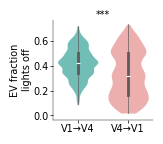

In [27]:
dir_monkey_df_lights_off = make_monkey_df_directionality(monkey_stats, dataset_types=['RS'])
plot_directionalities(dir_monkey_df_lights_off, x='Direction', neuron_property='EV', 
                      neuron_property_label='EV fraction\nlights off', linewidth=0,animal='monkey')